In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
from sklearn.cluster import KMeans

In [2]:
DATA_PATH = Path("Trips_2018.csv")

chunk_iter = pd.read_csv(DATA_PATH, chunksize=500000, low_memory=True)  # 0.5M rows per chunk

chunks = []
for i, chunk in enumerate(chunk_iter):
    print("Loaded chunk:", i, "→ rows:", len(chunk))
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
print("Combined shape:", df.shape)

Loaded chunk: 0 → rows: 500000
Loaded chunk: 1 → rows: 500000
Loaded chunk: 2 → rows: 500000
Loaded chunk: 3 → rows: 500000
Loaded chunk: 4 → rows: 500000
Loaded chunk: 5 → rows: 500000
Loaded chunk: 6 → rows: 500000
Loaded chunk: 7 → rows: 500000
Loaded chunk: 8 → rows: 500000
Loaded chunk: 9 → rows: 500000
Loaded chunk: 10 → rows: 500000
Loaded chunk: 11 → rows: 500000
Loaded chunk: 12 → rows: 500000
Loaded chunk: 13 → rows: 500000
Loaded chunk: 14 → rows: 500000
Loaded chunk: 15 → rows: 500000
Loaded chunk: 16 → rows: 500000
Loaded chunk: 17 → rows: 500000
Loaded chunk: 18 → rows: 500000
Loaded chunk: 19 → rows: 500000
Loaded chunk: 20 → rows: 500000
Loaded chunk: 21 → rows: 500000
Loaded chunk: 22 → rows: 500000
Loaded chunk: 23 → rows: 500000
Loaded chunk: 24 → rows: 500000
Loaded chunk: 25 → rows: 500000
Loaded chunk: 26 → rows: 500000
Loaded chunk: 27 → rows: 500000
Loaded chunk: 28 → rows: 500000
Loaded chunk: 29 → rows: 500000
Loaded chunk: 30 → rows: 500000
Loaded chunk: 31 →

In [3]:
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

#Convert start and stop times to proper datetime format
df["starttime"] = pd.to_datetime(df["starttime"], errors="coerce")
df["stoptime"]  = pd.to_datetime(df.get("stoptime"), errors="coerce")


#Create a new column 'start_hour' — the trip’s start time rounded down to the hour (used later to join with hourly weather data)
df["start_hour"] = df["starttime"].dt.floor("h")

#Compute trip duration in minutes
df["trip_duration_min"] = (
    df["tripduration"]/60.0
    if "tripduration" in df.columns
    else (df["stoptime"] - df["starttime"]).dt.total_seconds()/60
)

#Find a representative latitude and longitude for weather data Using median coordinates ensures one central location (e.g., NYC center)
LAT, LON = df["start_station_latitude"].median(), df["start_station_longitude"].median()

#Find the overall date range of the dataset for API query
START = df["start_hour"].min().date().isoformat()
END   = df["start_hour"].max().date().isoformat()

#Print a quick summary
print(f"Trips: {len(df)}  |  Date span: {START} → {END}")
df.head()

Trips: 17548339  |  Date span: 2018-01-01 → 2018-12-31


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_hour,trip_duration_min
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,2018-01-01 13:00:00,16.166667
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,2018-01-01 15:00:00,12.050000
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,2018-01-01 15:00:00,8.266667
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,2018-01-01 15:00:00,5.100000
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,2018-01-01 18:00:00,5.100000


In [4]:
stations = df[["start_station_id", "start_station_latitude", "start_station_longitude"]].drop_duplicates()

# 1) Build a small grid (≈2–3 km) to reduce API calls
GRID = 0.03  # ↑ 0.05 fewer calls, ↓ 0.02 more detail

stations = stations.copy()
stations["lat_bin"] = (stations["start_station_latitude"]  / GRID).round().astype(int)
stations["lon_bin"] = (stations["start_station_longitude"] / GRID).round().astype(int)
stations["cell_id"] = stations["lat_bin"].astype(str) + "_" + stations["lon_bin"].astype(str)

cells = (stations.groupby("cell_id", as_index=False)
         .agg(lat=("start_station_latitude", "median"),
              lon=("start_station_longitude", "median")))

print(f"Unique grid cells to fetch: {len(cells)}")


# 2) Helper: polite, retrying fetch per cell
def fetch_cell(lat, lon, start_date, end_date, retries=5, pause=1.5):
    url = "https://archive-api.open-meteo.com/v1/era5"
    hourly_vars = [
        "temperature_2m","apparent_temperature","rain","snowfall",
        "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
    ]
    params = {
        "latitude": float(lat), "longitude": float(lon),
        "start_date": start_date, "end_date": end_date,
        "timezone": "America/New_York",
        "hourly": ",".join(hourly_vars)  # more robust than list for some clients
    }
    last_err = None
    for a in range(retries):
        try:
            resp = requests.get(url, params=params, timeout=40)
            if resp.ok:
                js = resp.json()
                if "hourly" in js:
                    wx = pd.DataFrame(js["hourly"])
                    wx["start_hour"] = pd.to_datetime(wx["time"])
                    wx = wx.drop(columns=["time"])
                    # downcast floats to save memory
                    for c in wx.columns:
                        if c != "start_hour" and pd.api.types.is_float_dtype(wx[c]):
                            wx[c] = pd.to_numeric(wx[c], downcast="float")
                    return wx
                else:
                    last_err = f"no 'hourly' in response (keys={list(js.keys())})"
            else:
                last_err = f"HTTP {resp.status_code}: {resp.text[:160]}"
        except Exception as e:
            last_err = str(e)
        time.sleep(pause * (a + 1))  # gentle backoff
    # Uncomment for debugging:
    # print(f"Fetch failed for ({lat:.4f},{lon:.4f}): {last_err}")
    return None


# 3) Fetch once per cell
cell_weather, failed_cells = [], []
for _, r in cells.iterrows():
    wx_cell = fetch_cell(r["lat"], r["lon"], START, END)
    if wx_cell is None:
        failed_cells.append(r["cell_id"])
        continue
    wx_cell["cell_id"] = r["cell_id"]
    cell_weather.append(wx_cell)
    time.sleep(0.2)  # pacing

# --- Fallback if everything failed: use single (city-median) point ---
if not cell_weather:
    print(" All grid cells failed. Falling back to city-median weather…")
    lat0 = float(df["start_station_latitude"].median())
    lon0 = float(df["start_station_longitude"].median())
    wx_city = fetch_cell(lat0, lon0, START, END)
    if wx_city is None:
        raise RuntimeError(
            f"No weather fetched even for city median. Check network/date range. START={START}, END={END}"
        )
    wx_city["cell_id"] = "city_median"
    wx_cells = wx_city.copy()
    stations2 = stations.copy()
    stations2["use_cell"] = "city_median"
else:
    wx_cells = pd.concat(cell_weather, ignore_index=True)
    print(f"Weather rows (cells): {len(wx_cells)} | cells covered: {wx_cells['cell_id'].nunique()}")

    # 4) If some cells failed, borrow weather from nearest fetched cell
    if failed_cells:
        print("Filling missing cells from nearest fetched cell…")

        have = cells[cells["cell_id"].isin(wx_cells["cell_id"].unique())].copy()
        need = cells[cells["cell_id"].isin(failed_cells)].copy()

        def haversine(lat1, lon1, lat2, lon2):
            R = 6371.0
            lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
            dlat, dlon = lat2 - lat1, lon2 - lon1
            a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
            return 2 * R * np.arcsin(np.sqrt(a))

        alias_rows = []
        H_lat = have["lat"].to_numpy()
        H_lon = have["lon"].to_numpy()
        for _, r in need.iterrows():
            d = haversine(r["lat"], r["lon"], H_lat, H_lon)
            nearest = have.iloc[d.argmin()]["cell_id"]
            alias_rows.append((r["cell_id"], nearest))
        alias = pd.DataFrame(alias_rows, columns=["cell_id", "use_cell"])
    else:
        alias = pd.DataFrame(columns=["cell_id", "use_cell"])

    # Stations use their own cell if fetched, otherwise the nearest fetched cell
    stations2 = stations.merge(alias, on="cell_id", how="left")
    stations2["use_cell"] = stations2["use_cell"].fillna(stations2["cell_id"])

# 5) Expand cell weather back to stations
wx = (stations2[["start_station_id", "use_cell"]]
      .rename(columns={"use_cell": "cell_id"})
      .merge(wx_cells, on="cell_id", how="left"))

print("Total weather rows (expanded to stations):", len(wx))

Unique grid cells to fetch: 26
Weather rows (cells): 227760 | cells covered: 26
Total weather rows (expanded to stations): 8050440


In [5]:
is_station_level = "start_station_id" in wx.columns

if is_station_level:
    df["start_station_id"] = pd.array(df["start_station_id"], dtype="Int32")
    wx["start_station_id"] = pd.array(wx["start_station_id"], dtype="Int32")

key_cols = ["start_hour"] + (["start_station_id"] if is_station_level else [])

print("Merging on:", key_cols)

# keep only weather fields we actually need (saves memory) if present
wanted_wx = [
    "start_hour", "start_station_id",
    "temperature_2m","apparent_temperature","rain","snowfall",
    "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
]

wx_subset = wx[[c for c in wanted_wx if c in wx.columns]].copy()
if is_station_level and "start_station_id" in wx_subset.columns:
    wx_subset["start_station_id"] = pd.array(wx_subset["start_station_id"], dtype="Int32")

wx_keyed = wx_subset.drop_duplicates(subset=key_cols)

dfm = df.merge(
    wx_keyed,
    on=key_cols,
    how="left",          # keep all trips/columns from df
    validate="m:1",      # many trips to one weather row
    copy=False
)

# merge quality
miss_pct = dfm["temperature_2m"].isna().mean() * 100
print(f"Merge complete | rows={len(dfm):,} | weather coverage={100 - miss_pct:.1f}%")

dfm.head()

Merging on: ['start_hour', 'start_station_id']
Merge complete | rows=17,548,339 | weather coverage=100.0%


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,...,start_hour,trip_duration_min,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,relative_humidity_2m,cloud_cover,visibility
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,...,2018-01-01 13:00:00,16.166667,-8.1,-14.9,0.0,0.0,20.400000,30,0,None
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,...,2018-01-01 15:00:00,12.050000,-6.9,-13.7,0.0,0.0,19.700001,24,55,None
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,...,2018-01-01 15:00:00,8.266667,-6.9,-13.7,0.0,0.0,19.700001,24,55,None
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,...,2018-01-01 15:00:00,5.100000,-6.9,-13.7,0.0,0.0,19.700001,24,55,None
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,...,2018-01-01 18:00:00,5.100000,-10.0,-15.0,0.0,0.0,7.400000,39,23,None


In [7]:
#Feature engineering: concise, robust, memory-friendly ===

need = ["temperature_2m","rain","snowfall","wind_speed_10m","cloud_cover","visibility"]
for c in need:
    if c not in dfm.columns:
        dfm[c] = np.nan
dfm[need] = dfm[need].apply(pd.to_numeric, errors="coerce")

# 1) Temperature (°C) + readable buckets
dfm["temp_celsius"] = dfm["temperature_2m"]
dfm["temp_category"] = pd.cut(
    dfm["temp_celsius"],
    bins=[-99, 0, 10, 20, 25, 30, 99],
    labels=["freezing","cold","cool","comfortable","warm","hot"]
)

# 2) Dryness (1 dry, 0 wet)
rain  = dfm["rain"].fillna(0)
snow  = dfm["snowfall"].fillna(0)
dfm["is_dry"] = ((rain + snow) == 0).astype("int8")

# 3) Wind, sky, visibility
dfm["wind_kmh"] = dfm["wind_speed_10m"] * 3.6
dfm["sky_condition"] = pd.cut(
    dfm["cloud_cover"],
    bins=[-1, 25, 50, 75, 100.1],
    labels=["clear","partly_cloudy","cloudy","overcast"]
)
dfm["visibility_km"] = dfm["visibility"] / 1000.0

# 4) Cycling Score (0–100): temp comfort 40% + dryness 30% + low wind 20% + visibility 10%
dfm["cycling_score"] = (
    np.exp(-((dfm["temp_celsius"] - 20) / 10) ** 2) * 40           # temperature comfort peak ~20°C
    + dfm["is_dry"] * 30                                           # dry bonus
    + (dfm["wind_kmh"] < 20).astype("int8") * 20                   # calm wind
    + (dfm["visibility_km"] > 5).astype("int8") * 10               # clear view
).clip(0, 100)

# 5) Compact memory for categories
dfm["temp_category"] = dfm["temp_category"].astype("category")
dfm["sky_condition"]  = dfm["sky_condition"].astype("category")

print(f"Weather features added | shape={dfm.shape} | new cols: "
      f"['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']")
dfm.head()

Weather features added | shape=(17548339, 30) | new cols: ['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,...,relative_humidity_2m,cloud_cover,visibility,temp_celsius,temp_category,is_dry,wind_kmh,sky_condition,visibility_km,cycling_score
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,...,30,0,NaN,-8.1,freezing,1,73.439995,clear,NaN,30.014887
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,...,24,55,NaN,-6.9,freezing,1,70.919998,cloudy,NaN,30.028805
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,...,24,55,NaN,-6.9,freezing,1,70.919998,cloudy,NaN,30.028805
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,...,24,55,NaN,-6.9,freezing,1,70.919998,cloudy,NaN,30.028805
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,...,39,23,NaN,-10.0,freezing,1,26.639999,clear,NaN,30.004936


In [8]:
# Add temporal columns needed for analysis
dfm['day_of_week'] = dfm['starttime'].dt.dayofweek
dfm['is_weekend'] = (dfm['day_of_week'] >= 5).astype(int)
dfm['hour'] = dfm['start_hour'].dt.hour
dfm['month'] = dfm['starttime'].dt.month

print(f"Dataset ready: {len(dfm):,} trips with weather and temporal features")

Dataset ready: 17,548,339 trips with weather and temporal features


In [9]:
hourly_demand = (
    dfm.groupby("start_hour", observed=True)
       .size()
       .rename("trip_count")
       .reset_index()
       .sort_values("start_hour")
       .reset_index(drop=True)
)

hourly_demand.head()

,start_hour,trip_count
0,2018-01-01 00:00:00,119
1,2018-01-01 01:00:00,168
2,2018-01-01 02:00:00,98
3,2018-01-01 03:00:00,72
4,2018-01-01 04:00:00,34


In [10]:
pickups = (
    df.groupby(['start_station_id', 'start_hour'])
      .size()
      .reset_index(name='pickups')
      .rename(columns={'start_station_id': 'station_id', 'start_hour': 'hour'})
)
dropoffs = (
    df.groupby(['end_station_id', 'start_hour'])
      .size()
      .reset_index(name='dropoffs')
      .rename(columns={'end_station_id': 'station_id', 'start_hour': 'hour'})
)

hourly_demand1= pd.merge(pickups, dropoffs, on=['station_id', 'hour'], how='outer').fillna(0)

hourly_demand1['pickups']= hourly_demand1['pickups'].astype(int)
hourly_demand1['dropoffs']= hourly_demand1['dropoffs'].astype(int)

min_hour = hourly_demand1['hour'].min()
max_hour = hourly_demand1['hour'].max() 
all_hours = pd.date_range(min_hour, max_hour, freq='h')

stations = hourly_demand1['station_id'].unique()
index = pd.MultiIndex.from_product([stations, all_hours], names=['station_id', 'hour'])

hourly_demand1 = hourly_demand1.set_index(['station_id', 'hour']).reindex(index, fill_value=0).reset_index() 
hourly_demand1.head(90)

,station_id,hour,pickups,dropoffs
0,72.0,2018-01-01 00:00:00,0,0
1,72.0,2018-01-01 01:00:00,0,0
2,72.0,2018-01-01 02:00:00,0,0
3,72.0,2018-01-01 03:00:00,0,0
4,72.0,2018-01-01 04:00:00,0,0
...,...,...,...,...
85,72.0,2018-01-04 13:00:00,0,0
86,72.0,2018-01-04 14:00:00,0,0
87,72.0,2018-01-04 15:00:00,1,0
88,72.0,2018-01-04 16:00:00,0,0


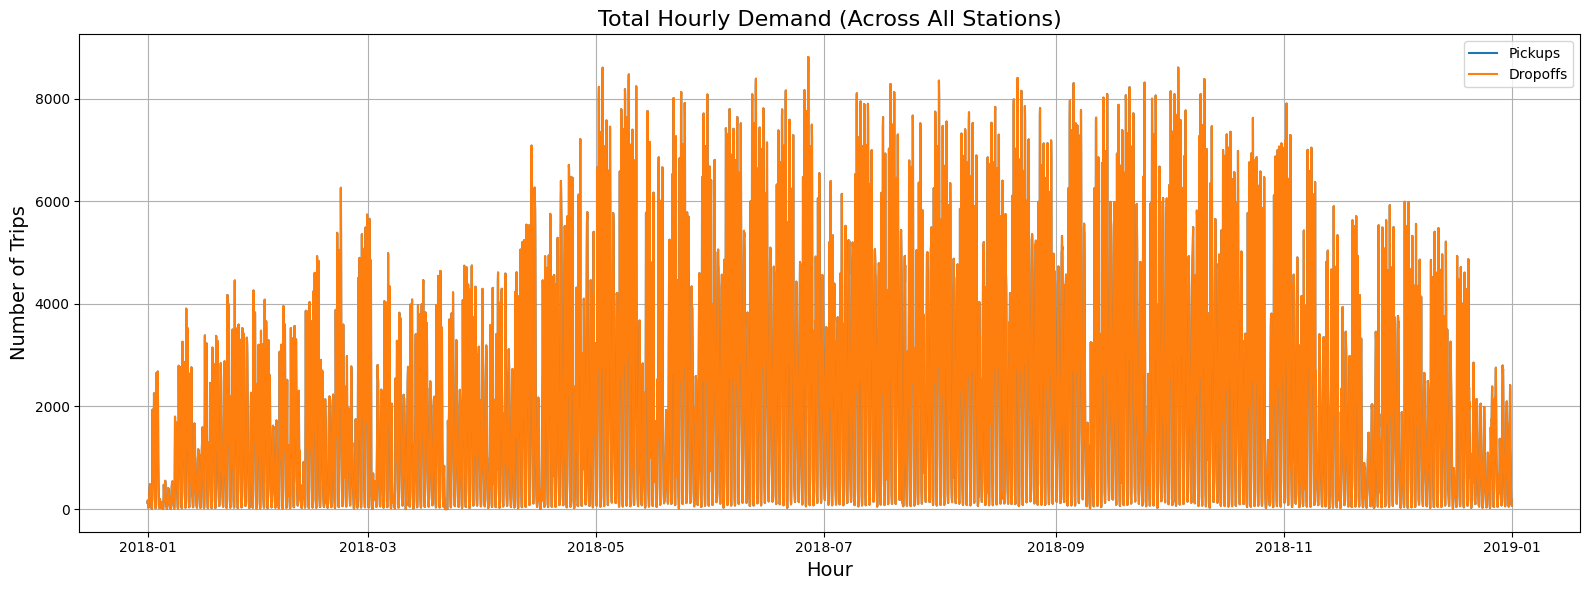

In [11]:
total_hourly = hourly_demand1.groupby("hour")[["pickups", "dropoffs"]].sum()

plt.figure(figsize=(16,6))
plt.plot(total_hourly.index, total_hourly["pickups"], label="Pickups")
plt.plot(total_hourly.index, total_hourly["dropoffs"], label="Dropoffs")

plt.title("Total Hourly Demand (Across All Stations)", fontsize=16)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Number of Trips", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


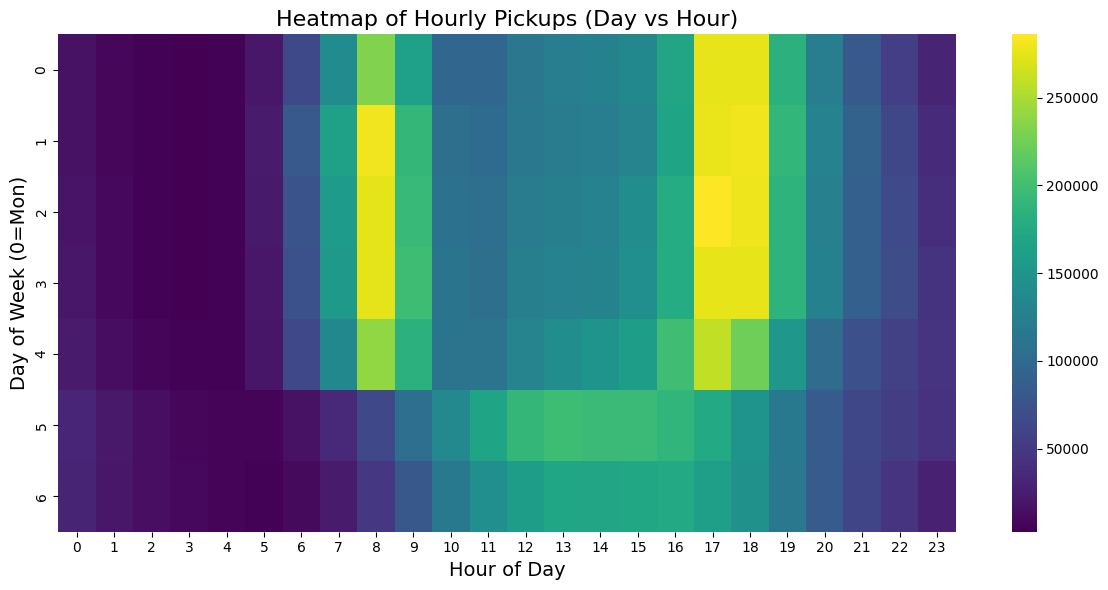

In [12]:
# Create hour-of-day & day-of-week fields
hourly_demand1['hour_of_day'] = hourly_demand1['hour'].dt.hour
hourly_demand1['day_of_week'] = hourly_demand1['hour'].dt.dayofweek  # 0=Monday

# Aggregate pickups by hour & day of week
heatmap_df = hourly_demand1.groupby(["day_of_week", "hour_of_day"])["pickups"].sum().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_df, cmap="viridis")

plt.title("Heatmap of Hourly Pickups (Day vs Hour)", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Day of Week (0=Mon)", fontsize=14)
plt.tight_layout()
plt.show()


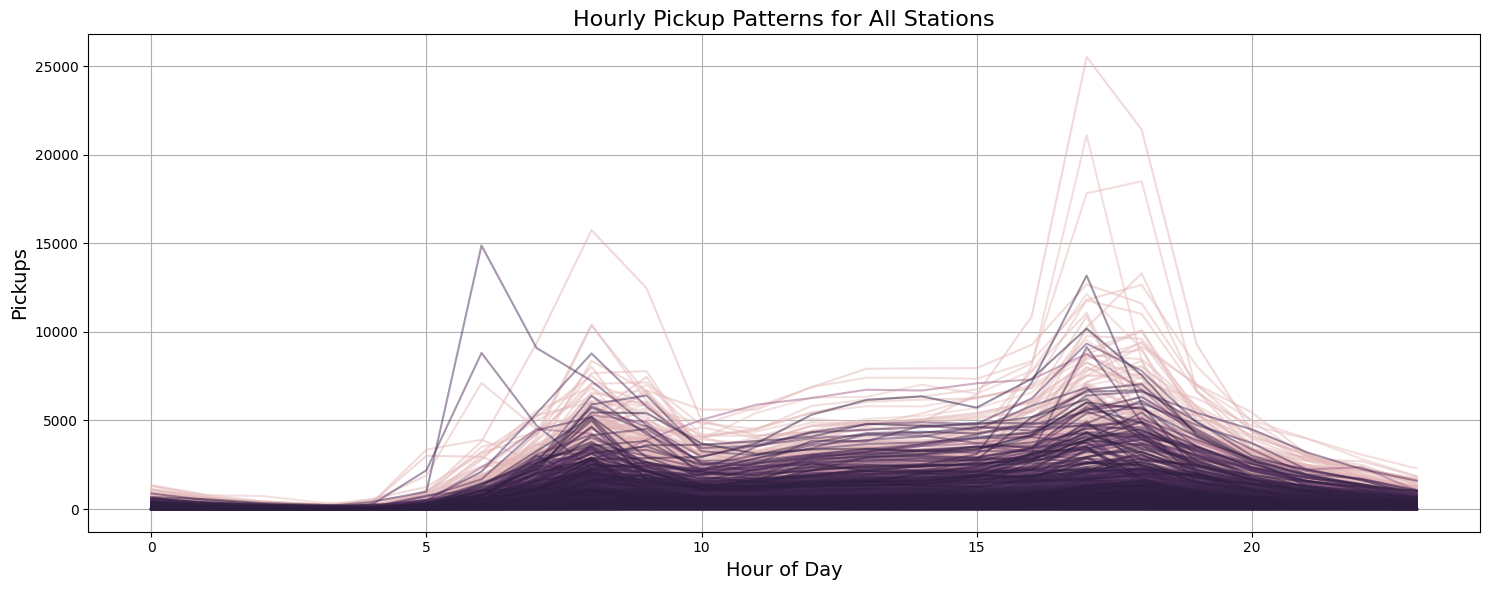

In [13]:
# Average hourly demand per station
station_hour = hourly_demand1.groupby(["station_id", "hour_of_day"])["pickups"].sum().reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(data=station_hour, x="hour_of_day", y="pickups", hue="station_id", legend=False, alpha=0.5)

plt.title("Hourly Pickup Patterns for All Stations", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Pickups", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


Number of unique stations: 850


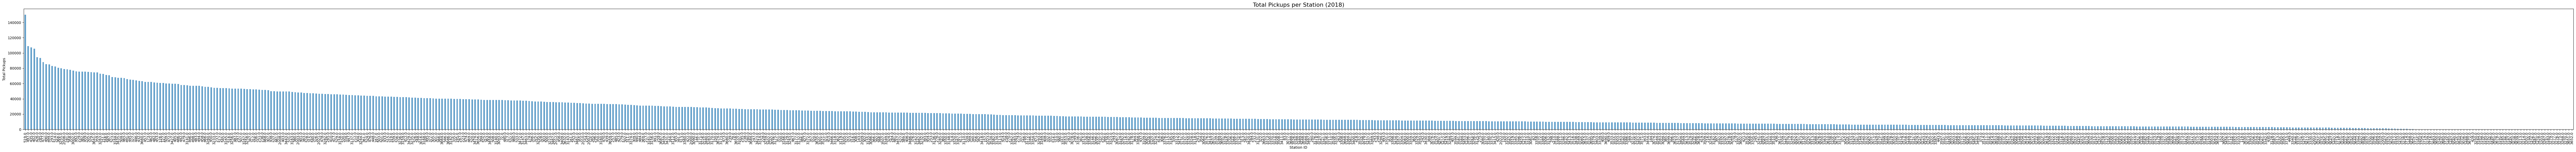

In [14]:
unique_stations = hourly_demand1['station_id'].nunique()
print(f"Number of unique stations: {unique_stations}")

station_totals = (
    hourly_demand1.groupby("station_id")["pickups"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(100,6))
station_totals.plot(kind='bar', alpha=0.7)

plt.title("Total Pickups per Station (2018)", fontsize=16)
plt.xlabel("Station ID")
plt.ylabel("Total Pickups")
plt.tight_layout()
plt.show()


# Clustering

In [15]:
start_meta = df.groupby("start_station_id")[
    ["start_station_latitude", "start_station_longitude"]
].mean().reset_index().rename(columns={
    "start_station_id": "station_id",
    "start_station_latitude": "lat",
    "start_station_longitude": "lon"
})

end_meta = df.groupby("end_station_id")[
    ["end_station_latitude", "end_station_longitude"]
].mean().reset_index().rename(columns={
    "end_station_id": "station_id",
    "end_station_latitude": "lat",
    "end_station_longitude": "lon"
})

# Combine both tables
stations_meta = pd.concat([start_meta, end_meta], ignore_index=True)

# If the same station appears in both start & end tables, take average again
stations_meta = stations_meta.groupby("station_id")[["lat", "lon"]].mean().reset_index()

print("Number of unique stations:", len(stations_meta))
stations_meta.head()

Number of unique stations: 850


,station_id,lat,lon
0,72.0,40.767272,-73.993929
1,79.0,40.719116,-74.006667
2,82.0,40.711174,-74.000165
3,83.0,40.683826,-73.976323
4,119.0,40.696089,-73.978034


In [16]:
stations_meta = stations_meta[
    (stations_meta['lat'] > 40.4) &
    (stations_meta['lat'] < 41) &
    (stations_meta['lon'] > -74.1) &
    (stations_meta['lon'] < -73.7)
]

N_CLUSTERS = 25   # you can choose any number >= 20

kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    n_init='auto'
)

stations_meta["cluster"] = kmeans.fit_predict(stations_meta[["lat", "lon"]])

stations_meta.head()

,station_id,lat,lon,cluster
0,72.0,40.767272,-73.993929,1
1,79.0,40.719116,-74.006667,22
2,82.0,40.711174,-74.000165,14
3,83.0,40.683826,-73.976323,20
4,119.0,40.696089,-73.978034,20


In [18]:
# Merge clusters back into hourly_demand
hourly_demand1 = hourly_demand1.merge(
    stations_meta[["station_id", "cluster"]],
    on="station_id",
    how="left"
)
hourly_demand1

,station_id,hour,pickups,dropoffs,hour_of_day,day_of_week,cluster_x,cluster_y
0,72.0,2018-01-01 00:00:00,0,0,0,0,1.0,1.0
1,72.0,2018-01-01 01:00:00,0,0,1,0,1.0,1.0
2,72.0,2018-01-01 02:00:00,0,0,2,0,1.0,1.0
3,72.0,2018-01-01 03:00:00,0,0,3,0,1.0,1.0
4,72.0,2018-01-01 04:00:00,0,0,4,0,1.0,1.0
...,...,...,...,...,...,...,...,...
7445995,3721.0,2018-12-31 19:00:00,0,0,19,0,7.0,7.0
7445996,3721.0,2018-12-31 20:00:00,0,0,20,0,7.0,7.0
7445997,3721.0,2018-12-31 21:00:00,0,0,21,0,7.0,7.0
7445998,3721.0,2018-12-31 22:00:00,0,0,22,0,7.0,7.0


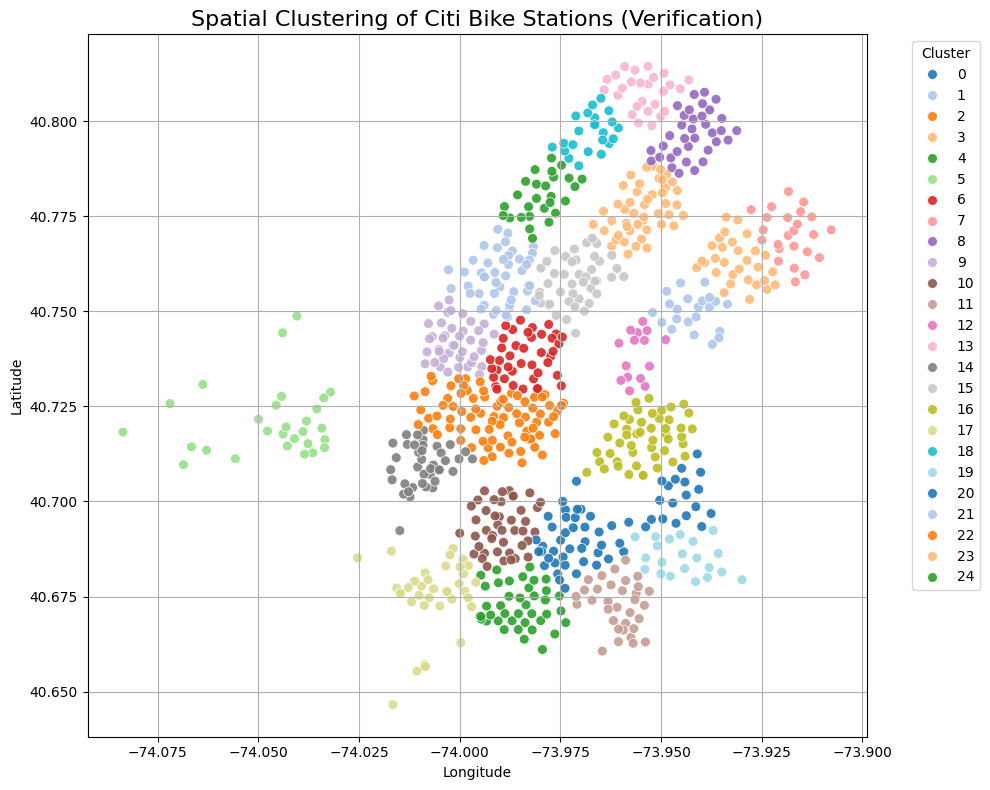

In [19]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=stations_meta,
    x="lon",
    y="lat",
    hue="cluster",
    palette="tab20",
    s=50,
    alpha=0.9
)

plt.title("Spatial Clustering of Citi Bike Stations (Verification)", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

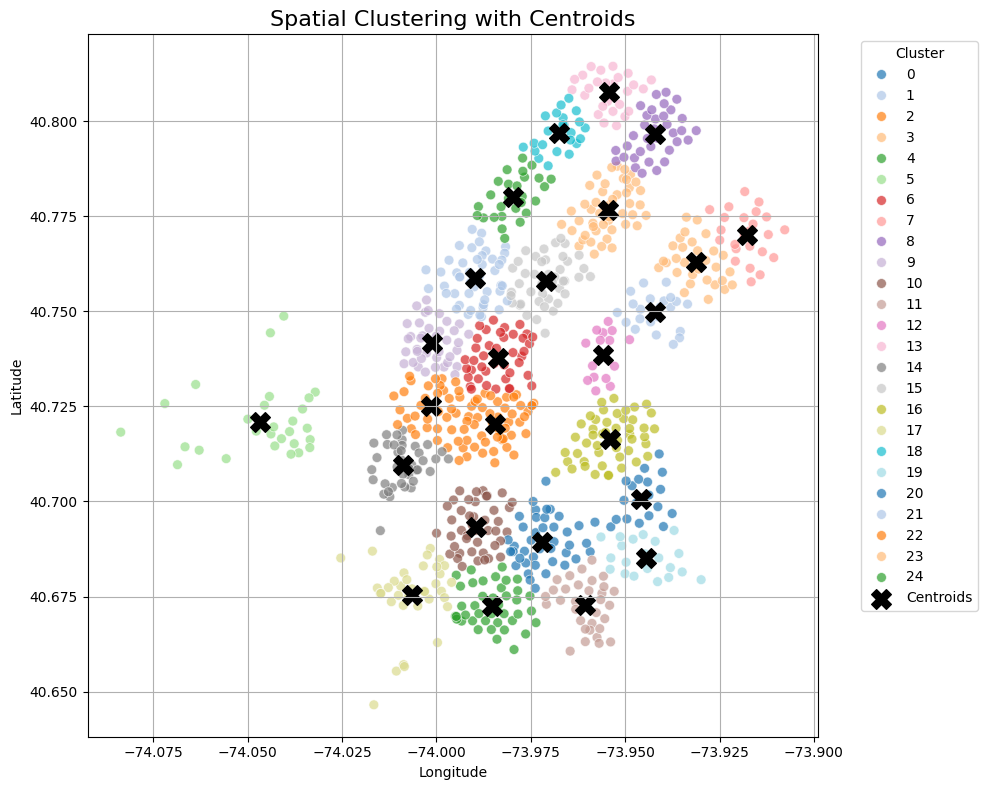

In [20]:
centroids = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))

# Plot stations
sns.scatterplot(
    data=stations_meta,
    x="lon",
    y="lat",
    hue="cluster",
    palette="tab20",
    s=50,
    alpha=0.7
)

# Plot centroids
plt.scatter(
    centroids[:,1],  # lon
    centroids[:,0],  # lat
    s=200,
    c="black",
    marker="X",
    label="Centroids"
)

plt.title("Spatial Clustering with Centroids", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# Merge cluster labels to hourly demand
hourly_cluster_demand = hourly_demand1.merge(
    stations_meta[['station_id', 'cluster']],
    on='station_id',
    how='left'
)
hourly_cluster_demand.head()


,station_id,hour,pickups,dropoffs,hour_of_day,day_of_week,cluster_x,cluster_y,cluster
0,72.0,2018-01-01 00:00:00,0,0,0,0,1.0,1.0,1.0
1,72.0,2018-01-01 01:00:00,0,0,1,0,1.0,1.0,1.0
2,72.0,2018-01-01 02:00:00,0,0,2,0,1.0,1.0,1.0
3,72.0,2018-01-01 03:00:00,0,0,3,0,1.0,1.0,1.0
4,72.0,2018-01-01 04:00:00,0,0,4,0,1.0,1.0,1.0
